In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# File and Data Field Descriptions

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
- sample_submission.csv - A submission file in the correct format.
    - PassengerId - Id for each passenger in the test set.
    - Transported - The target. For each passenger, predict either True or False.

# 파일 및 데이터 필드 설명
- train.csv - 승객의 약 3분의 2(~8700)에 대한 개인 기록으로, 훈련 데이터로 사용됩니다.
    - PassengerId - 각 승객의 고유 ID입니다. 각 ID는 ggg_pp 형식을 취하며, 여기서 ggg는 승객이 함께 여행하는 그룹을 나타내며, pp는 그룹 내 번호를 나타냅니다. 그룹의 사람들은 종종 가족 구성원이지만 항상 그렇지는 않다.
    - HomePlanet - 승객이 출발한 행성으로, 일반적으로 영구 거주지 행성입니다.
    - CryoSleep - 승객이 항해가 진행되는 동안 일시 정지 애니메이션으로 전환되도록 선택했는지 여부를 나타냅니다. 저온 수면 중인 승객들은 객실에 갇히게 된다.
    - 객실 - 승객이 머물고 있는 객실 번호입니다. 갑판/번호/측면 형식을 취합니다. 여기서 측면은 좌현에 P 또는 우현에 S가 될 수 있습니다.
    - 목적지 - 승객이 주차를 해제할 행성입니다.
    - 연령 - 승객의 연령입니다.
    - VIP - 승객이 여행 중 특별 VIP 서비스에 비용을 지불했는지 여부
    - 룸 서비스, 푸드 코트, 쇼핑 몰, 스파, VRDeck - 승객이 우주선 타이타닉의 많은 고급 편의 시설 각각에서 청구한 금액입니다.
    - 이름 - 승객의 이름과 성.
    - 운송됨 - 승객이 다른 차원으로 운송되었는지 여부. 예측하려는 대상 열입니다.
- test.csv - 테스트 데이터로 사용되는 나머지 승객의 1/3(~4300)에 대한 개인 기록. 작업은 이 세트의 승객에 대한 운송 값을 예측하는 것입니다.
- sample_submission.csv - 올바른 형식의 송신 파일.
    - PassengerId - 테스트 세트에 포함된 각 승객의 ID입니다.
    - Transported - 타겟. 각 승객에 대해 참 또는 거짓을 예측합니다.

## Imports

### **Installing LazyPredict :**

Check the offical Documentation of LazyPredict here : https://lazypredict.readthedocs.io

In [2]:
from IPython.display import clear_output
!pip3 install -U pandas #Upgrading pandas

clear_output()

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression



from lightgbm import LGBMClassifier

import time
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Preparation

In [4]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 15
FOLDS = 5
STRATEGY = 'median'

### Exploring Train Data :

📌  Observations in Train Data:
* There are total of 14 columns and 8693 rows in train data.
* Train data contains 119378 observation with 2324 missing values.
* All 12 feature columns have missing values in them with CryoSleep having highest missing values (217)
* Transported is the target variable which is only available in the train dataset.

### 훈련 데이터 탐색:

📌 훈련 데이터의 관측치:
* 훈련 데이터에는 총 14개의 열과 8693개의 행이 있습니다.
* 훈련 데이터에는 2324개의 결측값이 있는 119378 관측치가 포함되어 있습니다.
* 모든 12개의 피쳐 열에 결측값이 있으며, CryoSleep은 결측값이 가장 높습니다(217).
* Transported는 열차 데이터 집합에서만 사용할 수 있는 대상 변수입니다.

#### Quick view of Train Data:

Below are the first 5 rows of train dataset:

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of vlues in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of vlues in train data: 119378
Number missing values in train data: 2324


#### Column Wise missing values:

In [7]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


- 결측치 / 변수타입 확인

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


#### Basic statistics of training data:

Below is the basic statistics for each variables which contain information on count, mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum.

In [9]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


- 스케일이 달라서 표준화가 필요함

In [10]:
space_input = train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].to_numpy()
space_target = train['Transported'].to_numpy()

print(space_input.shape, space_target.shape)

(8693, 6) (8693,)


- 검증세트 만들기

In [11]:
sub_input, val_input, sub_target, val_target = train_test_split(
    space_input, space_target, test_size = 0.2, random_state = 42
)

print(sub_input.shape, val_input.shape, space_input.shape)

(6954, 6) (1739, 6) (8693, 6)


In [12]:
ss = StandardScaler()
ss.fit(sub_input)
train_scaled = ss.transform(sub_input)
test_scaled = ss.transform(val_input)

### Exploring Test Data

📌  Observations in Test Data:
* There are total of 13 columns and 4277 rows in test data.
* Train data contains 54484 observation with 1117 missing values.
* All 12 feature columns have missing values in them with FoodCourt having highest missing values (106)

### 테스트 데이터 탐색

📌 테스트 데이터의 관측치:
* 테스트 데이터에는 총 13개의 열과 4277개의 행이 있습니다.
* 훈련 데이터에는 결측값이 1117개인 54484개의 관측치가 포함되어 있습니다.
* 모든 12개 피쳐 열에 결측값이 있으며 FoodCourt의 결측값이 가장 높습니다(106).

#### Quick view of Test Data

In [13]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [14]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values  in test data: {sum(test.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
No of rows with missing values  in test data: 1117


#### Column Wise missing values

In [15]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


#### Basic statistics of test data 

Below is the basic statistics for each variables which contain information on count, mean, standard deviation, minimum, 1st quartile, median, 3rd quartile and maximum.

In [16]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


### Submission File

#### Quick view of submission File

In [17]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# EDA

### Overview of Data

In [18]:
train.drop(['PassengerId'] , axis = 1 , inplace = True)
test.drop(['PassengerId'] , axis = 1 , inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col not in ['id', TARGET]]
RANDOM_STATE = 15

In [19]:
train.iloc[:, :-1].describe().T.sort_values(by = 'std', ascending = False)\
                    .style.background_gradient(cmap = 'GnBu')\
                    .bar(subset = ["max"], color = '#BB0000')\
                    .bar(subset = ["mean",], color = 'green')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


### Null Value Distribution

📌  Observations in Null Value Distribution :
* The maximum of missing value in an row is 3 and the lowest is no missing value
* Interestingly, the missing value distribution (row basis) is quite the same between train and test dataset.
* There are around 76% of the observations (row basis) that has no missing values.
* Rest 24% of the observations (row basis) that have 1 to 3 missing values

📌 Null 값 분포에서의 관측치:
* 행의 결측값 최대값은 3이고 가장 낮은 값은 결측값이 없습니다.
* 흥미롭게도, 결측값 분포 (행 기준)는 열차와 테스트 데이터 집합 간에 거의 동일합니다.
* 결측값이 없는 관측치(행 기준)의 약 76%가 있습니다.
* 결측값이 1 ~ 3개인 관측치의 나머지 24%(행 기준)

#### Column wise Null Value Distribution

In [20]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0, ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0, ascending = False)[:-1]

fig = make_subplots(rows = 1,
                    cols = 2,
                    column_titles = ["Train Data", "Test Data"],
                    x_title = "Missing Values")
# 참고 : https://plotly.com/python/subplots/

fig.add_trace(go.Bar(x = train_null[0],
                     y = train_null.index,
                     orientation = "h",
                     marker = dict(color = [n for n in range(12)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 2,
                                   coloraxis = "coloraxis")),
              1, 1)
# 참고 : https://plotly.com/python/creating-and-updating-figures/

fig.add_trace(go.Bar(x = test_null[0],
                     y = test_null.index,
                     orientation = "h",
                     marker = dict(color = [n for n in range(12)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 2,
                                   coloraxis = "coloraxis")),
              1, 2)

fig.update_layout(showlegend = False, title_text = "Column wise Null Value Distribution", title_x = 0.5)
# showlegend는 범례, title_text는 타이틀 텍스트, title_x는 타이틀의 x좌표
# 참고 : https://plotly.com/python/reference/layout/

#### Row wise Null Value Distribution

In [21]:
missing_train_row = train.isna().sum(axis = 1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis = 1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"] * 100
missing_test_row["count"] = missing_test_row["count"] * 100

fig = make_subplots(rows = 1,
                    cols = 2,
                    column_titles = ["train Data", "Test Data"],
                    x_title = "Missing Values")

fig.add_trace(go.Bar(x = missing_train_row["no"],
                     y = missing_train_row["count"],
                     marker = dict(color = [n for n in range(4)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 3,
                                   coloraxis = "coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x = missing_test_row["no"],
                     y = missing_test_row["count"],
                     marker = dict(color = [n for n in range(4)],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 3,
                                   coloraxis = "coloraxis")),
              1, 2)

fig.update_layout(showlegend = False, title_text = "Row wise Null Value Distribution", title_x = 0.5)

#### Dealing with missing value (reference)

Some references on how to deal with missing value:

- Missing Values by Alexis Cook
- Data Cleaning Challenge: Handling missing values by Rachael Tatman
- A Guide to Handling Missing values in Python by Parul Pandey

Some models that have capability to handle missing value by default are:

- XGBoost: https://xgboost.readthedocs.io/en/latest/faq.html
- LightGBM: https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
- Catboost: https://catboost.ai/docs/concepts/algorithm-missing-values-processing.html

### Continuos and Categorical Data Distribution

📌  Observations in Null Value Distribution :
* Out of 12 features 6 features are continous, 2 features are text data and 4 features are categorical.
* HomePlanet and Destination have 3 differnt unique values.
* CryoSleep and VIP are bool features

📌 Null 값 분포에서의 관측치:
* 12가지 특징 중 6가지 특징이 연속적이며, 2가지 특징이 텍스트 데이터이며, 4가지 특징이 범주형입니다.
* HomePlanet 및 Destination에는 3개의 다른 고유 값이 있습니다.
* CryoSleep과 VIP는 부울 기능

In [22]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis = 0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features]

del df

print(f'\033[94mTotal number of features : {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels = ['Categorical', 'Continous', 'Text']
values = [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data = [go.Pie(
    labels = labels,
    values = values, pull = [0.1, 0, 0],
    marker = dict(colors = colors,
                  line = dict(color = '#000000',
                              width = 2)))])

fig.show()

Total number of features : 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


### Feature Distribution of Continous Features

#### Distribution of Age

In [23]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf,
                   x = "Age",
                   color = "type",
                   color_discrete_sequence = ['#58D68D', '#DE3163'],
                   marginal = "box",
                   nbins = 100,
                   template = "plotly_white")

fig.update_layout(title = "Distribution of Age", title_x = 0.5)
fig.show()

### Feature Distribution of Categorical Features

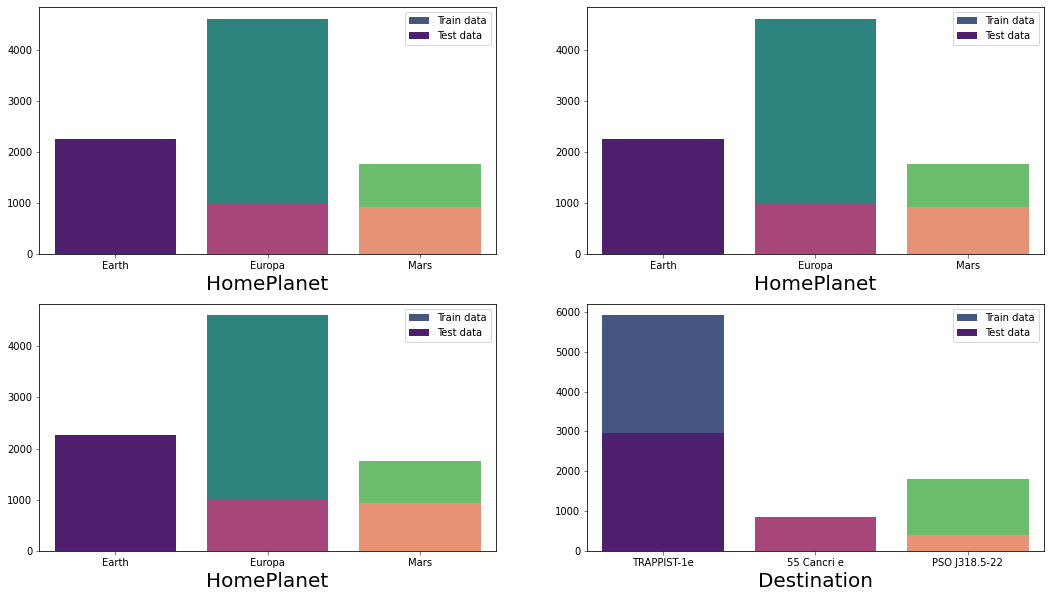

In [24]:
if (len(cat_features) == 0) :
    print("No Categorical features")
else :
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize = (18, 10))
    for r in range(nrows) :
        for c in range(ncols) :
            col = cat_features[r * ncols * c]
            sns.countplot(train[col], ax = axes[r, c], palette = "viridis", label = 'Train data')
            sns.countplot(test[col], ax = axes[r, c], palette = "magma", label = 'Test data')
            axes[r, c].legend()
            axes[r, c].set_ylabel('')
            axes[r, c].set_xlabel(col, fontsize = 20)
            axes[r, c].tick_params(labelsize = 10, width = 0.5)
            axes[r, c].xaxis.offsetText.set_fontsize(4)
            axes[r, c].yaxis.offsetText.set_fontsize(4)
    
    plt.show()

### Target Distribution

📌  Observations in Null Value Distribution :
* There are two target values - 0 and 1.
* Both the target values are almost equally distributed.

📌 Null 값 분포에서의 관측치:
* 목표값에는 0과 1의 두 가지가 있습니다.
* 두 목표값은 거의 균등하게 분포되어 있습니다.

In [25]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame = target_df,
             x = TARGET,
             y = 'count')

fig.update_traces(marker_color = ['#58D68D', '#DE3163'],
                  marker_line_color = 'rgb(0, 0, 0)',
                  marker_line_width = 2)

fig.update_traces(marker_color = ['#58D68D', '#DE3163'], 
                  marker_line_color = 'rgb(0,0,0)',
                  marker_line_width = 2)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] * 100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1] * 100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


### Correlation matrix

In [26]:
fig = px.imshow(train.corr(), text_auto = True, aspect = "auto", color_continuous_scale = "viridis")

fig.show()

# Data Pre-Processing

#### Imputing Missing Values

In [27]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]
imputer = SimpleImputer(strategy = STRATEGY)
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace = True)
test["HomePlanet"].fillna('Z', inplace = True)

#### Encoding Categorical Features

In [28]:
label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]

def label_encoder(train, test, columns) :
    for col in columns :
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
        
    return train, test

train, test = label_encoder(train, test, label_cols)

In [29]:
train.drop(["Name", "Cabin"], axis = 1, inplace = True)
test.drop(["Name", "Cabin"], axis = 1, inplace = True)
X = train.drop(TARGET, axis = 1)
Y = train[TARGET]
X_train, X_test, Y_train, Y_test = train_test_split(X, X, random_state = 15, test_size = 0.33)

# Step 1. 라이브러리 및 데이터 불러오기

- 라이브러리 버전 확인

# Step 2. 탐색적 자료 분석(EDA)

- 데이터 시각화
- 산점도, 막대 그래프 등
- 그래프 해석해서 설명을 달아야 함
- 약간의 데이터 전처리

# Step 3. 데이터 전처리

- Feature Engineering
- ML 모형을 돌리기 위해 표준화, 원핫-인코딩 등등등...
- 파생변수 (도출 변수) 생성
    + 왜 이 변수를 만들었는지에 대한 설명이 필요

# Step 4. 머신러닝 모형 개발

- 모형에 대한 설명 필요
- 모형을 1-2개 정도만 사용
- 교차 검증
- 하이퍼파라미터 튜닝

# Step 5. 모형 평가
- 훈련데이터를 꼬개서 훈련데이터와 검증데이터로 분류
- 정확도 비교
- 혼동행렬( Confusion Matrix) 설명

# Step 6. 제출

- 제출 양식은 샘플에 맞춰서

# Reference (참고)

- 다른 사람들의 code 설명을 보고 따라서 침
- 노트북 표절 방지 위해, 참조한 코드는 반드시 링크 걸어둘 것
- 저자 이름, 글 제목, 링크 주소

# 마감일

- 4월 12일 17시 40분
- 제출 형태
    + 개인 DM으로 Leaderboard 랭킹 사진 캡처
    + 고용노동부 보고 양식